In [46]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
class CausalDilatedConv1d(nn.Module):
    """
    Dilated causal convolution layer with padding to maintain temporal causality
    """
    def __init__(self, in_channels, out_channels, kernel_size=2, dilation=1):
        super(CausalDilatedConv1d, self).__init__()
        self.padding = (kernel_size - 1) * dilation  
        self.conv = nn.Conv1d(
            in_channels, out_channels, kernel_size,
            padding=self.padding, dilation=dilation
        )

    def forward(self, x):
        result = self.conv(x)
        return result[:, :, :-self.padding] if self.padding else result

In [48]:

class WeatherNetResidualBlock(nn.Module):
    """
    Residual block with gated activation units as in WaveNet
    """
    def __init__(self, channels, kernel_size, dilation):
        super(WeatherNetResidualBlock, self).__init__()
        
        self.dilated_conv = CausalDilatedConv1d(
            channels, channels * 2, kernel_size, dilation
        )

        self.residual_conv = nn.Conv1d(channels, channels, 1)

        self.skip_conv = nn.Conv1d(channels, channels, 1)
        
    def forward(self, x):
        
        conv_out = self.dilated_conv(x)
        filter_out, gate_out = torch.chunk(conv_out, 2, dim=1)
        
        gated_out = torch.tanh(filter_out) * torch.sigmoid(gate_out)
        
        residual = self.residual_conv(gated_out)
        skip = self.skip_conv(gated_out)
        
        return residual + x, skip


In [49]:


class WeatherNet(nn.Module):
    """
    WaveNet-inspired model adapted for weather forecasting
    """
    def __init__(self, 
                 input_channels, 
                 output_channels, 
                 residual_channels=32, 
                 skip_channels=32, 
                 kernel_size=2, 
                 num_blocks=3, 
                 num_layers_per_block=10,
                 forecast_horizon=24):

        super(WeatherNet, self).__init__()
        
        self.input_conv = nn.Conv1d(input_channels, residual_channels, 1)
        
        self.residual_blocks = nn.ModuleList()
        self.skip_connections = nn.ModuleList()
        
        for b in range(num_blocks):
            for i in range(num_layers_per_block):

                dilation = 2 ** i
                self.residual_blocks.append(
                    WeatherNetResidualBlock(residual_channels, kernel_size, dilation)
                )
                
        self.final_conv1 = nn.Conv1d(skip_channels, skip_channels, 1)
        self.final_conv2 = nn.Conv1d(skip_channels, output_channels * forecast_horizon, 1)
        self.forecast_horizon = forecast_horizon
        self.output_channels = output_channels
        
    def forward(self, x):

        x = self.input_conv(x)
        
        skip_sum = 0
    
        for block in self.residual_blocks:
            x, skip = block(x)
            skip_sum = skip_sum + skip
        
        x = F.relu(skip_sum)
        x = F.relu(self.final_conv1(x))
        x = self.final_conv2(x)
        
        
        x = x[:, :, -1]
        x = x.reshape(-1, self.output_channels, self.forecast_horizon)
        
        return x

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1462 entries, 2013-01-01 to 2017-01-01
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   meantemp      1462 non-null   float64
 1   humidity      1462 non-null   float64
 2   wind_speed    1462 non-null   float64
 3   meanpressure  1462 non-null   float64
dtypes: float64(4)
memory usage: 89.4 KB


In [60]:
test_size = 90
val_size = int((len(df) - test_size) * 0.1)
train_size = len(df) - test_size - val_size

train_data = df.iloc[:train_size]
val_data = df.iloc[train_size:train_size+val_size]
test_data = df.iloc[-test_size:]

print(f"\nData split: Train {train_data.shape}, Validation {val_data.shape}, Test {test_data.shape}")

scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_data)

val_scaled = scaler.transform(val_data)
test_scaled = scaler.transform(test_data)


Data split: Train (1235, 4), Validation (137, 4), Test (90, 4)


In [61]:
def create_sequences(data, seq_length, horizon=1):
    xs, ys = [], []
    for i in range(len(data) - seq_length - horizon + 1):
        x = data[i:(i + seq_length)]
        y = data[i + seq_length:i + seq_length + horizon, 1]  
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)


In [62]:
def create_sequences(data, seq_length, horizon=1):
    xs, ys = [], []
    for i in range(len(data) - seq_length - horizon + 1):
        x = data[i:(i + seq_length)]
        y = data[i + seq_length:i + seq_length + horizon, 1]  # 1 is the index of the humidity in df
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 30
forecast_horizon = 7

X_train, y_train = create_sequences(train_scaled, seq_length, forecast_horizon)
X_val, y_val = create_sequences(val_scaled, seq_length, forecast_horizon)
X_test, y_test = create_sequences(test_scaled, seq_length, forecast_horizon)

X_train_tensor = torch.FloatTensor(X_train).transpose(1, 2) 
y_train_tensor = torch.FloatTensor(y_train)

X_val_tensor = torch.FloatTensor(X_val).transpose(1, 2)
y_val_tensor = torch.FloatTensor(y_val)

X_test_tensor = torch.FloatTensor(X_test).transpose(1, 2)
y_test_tensor = torch.FloatTensor(y_test)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [63]:
seq_length = 14
forecast_horizon = 7

X_train, y_train = create_sequences(train_scaled, seq_length, forecast_horizon)
X_val, y_val = create_sequences(val_scaled, seq_length, forecast_horizon)
X_test, y_test = create_sequences(test_scaled, seq_length, forecast_horizon)


In [64]:
X_train_tensor = torch.FloatTensor(X_train).transpose(1, 2) 
y_train_tensor = torch.FloatTensor(y_train)

X_val_tensor = torch.FloatTensor(X_val).transpose(1, 2)
y_val_tensor = torch.FloatTensor(y_val)

X_test_tensor = torch.FloatTensor(X_test).transpose(1, 2)
y_test_tensor = torch.FloatTensor(y_test)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [65]:
input_channels = 4  
output_channels = 1 
residual_channels = 8
skip_channels = 8
kernel_size = 2
num_blocks = 2
num_layers_per_block = 3  

tcn_model = WeatherNet(
    input_channels=input_channels,
    output_channels=output_channels,
    residual_channels=residual_channels,
    skip_channels=skip_channels,
    kernel_size=kernel_size,
    num_blocks=num_blocks,
    num_layers_per_block=num_layers_per_block,
    forecast_horizon=forecast_horizon
)

learning_rate = 0.001
num_epochs = 30
early_stopping_patience = 10

criterion = nn.MSELoss()
optimizer = optim.Adam(tcn_model.parameters(), lr=learning_rate)

In [66]:
def train_tcn_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, patience):
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience_counter = 0
   

    for epoch in range(num_epochs):
        
        model.train()
        train_loss = 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
   
            outputs = outputs.squeeze(1)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        
       
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs)
                outputs = outputs.squeeze(1)
                loss = criterion(outputs, targets)
                val_loss += loss.item()
        
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
        
     
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'best_tcn_model.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f'Early stopping at epoch {epoch+1}')
                break
    
    model.load_state_dict(torch.load('best_tcn_model.pth'))
    return train_losses, val_losses


In [67]:
from torchviz import make_dot
print("\nTraining TCN model...")
train_losses, val_losses = train_tcn_model(
    tcn_model, 
    train_loader, 
    val_loader, 
    criterion, 
    optimizer, 
    num_epochs,
    early_stopping_patience
)

dummy_input = torch.zeros(32, 4, 14)  
 
tcn_model.eval()
test_loss = 0.0
test_preds = []
test_targets = []

with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = tcn_model(inputs)
        outputs = outputs.squeeze(1)
        loss = criterion(outputs, targets)
        test_loss += loss.item()
        
        test_preds.append(outputs.cpu().numpy())
        test_targets.append(targets.cpu().numpy())
output = tcn_model(dummy_input)
make_dot(output, params=dict(tcn_model.named_parameters())).render("tcn_model_computation_graph", format="png")

test_loss /= len(test_loader)
print(f'TCN Test Loss: {test_loss:.4f}')




Training TCN model...
Epoch 1/30, Train Loss: 0.7709, Val Loss: 0.3610
Epoch 2/30, Train Loss: 0.4387, Val Loss: 0.3324
Epoch 3/30, Train Loss: 0.3962, Val Loss: 0.3219
Epoch 4/30, Train Loss: 0.3889, Val Loss: 0.3760
Epoch 5/30, Train Loss: 0.3837, Val Loss: 0.3492
Epoch 6/30, Train Loss: 0.3773, Val Loss: 0.3310
Epoch 7/30, Train Loss: 0.3723, Val Loss: 0.3399
Epoch 8/30, Train Loss: 0.3694, Val Loss: 0.3316
Epoch 9/30, Train Loss: 0.3596, Val Loss: 0.3451
Epoch 10/30, Train Loss: 0.3542, Val Loss: 0.3456
Epoch 11/30, Train Loss: 0.3509, Val Loss: 0.3404
Epoch 12/30, Train Loss: 0.3467, Val Loss: 0.3501
Epoch 13/30, Train Loss: 0.3466, Val Loss: 0.3392
Early stopping at epoch 13
TCN Test Loss: 0.5580


Day 1 - RMSE: 9.1971, MSE: 84.5868, MAE: 6.5107


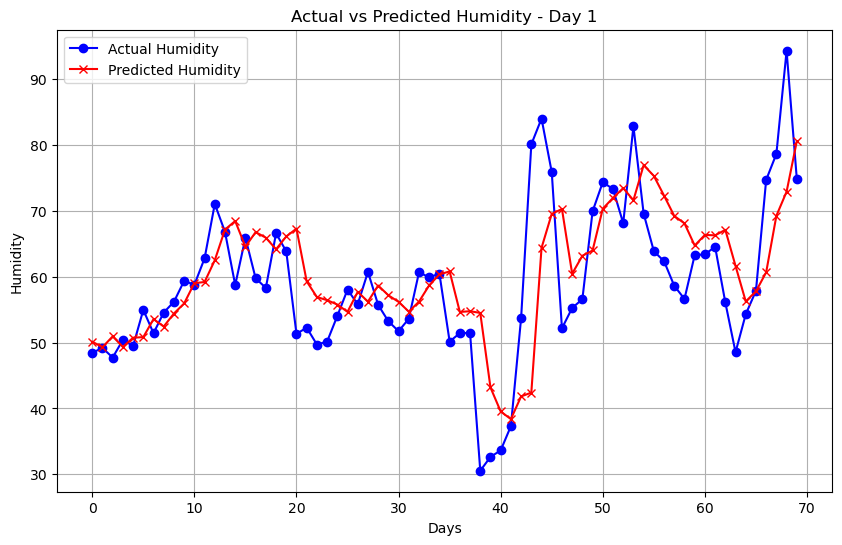

Day 2 - RMSE: 11.5711, MSE: 133.8912, MAE: 8.3418


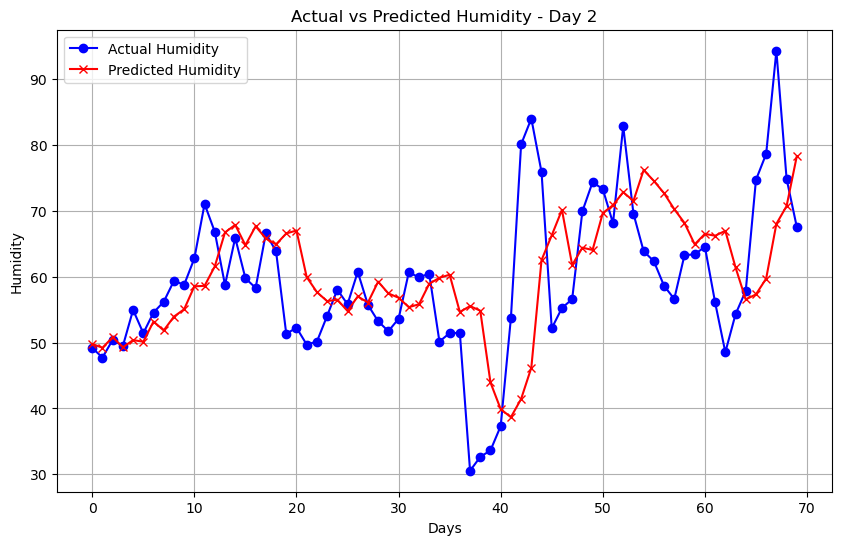

Day 3 - RMSE: 13.1763, MSE: 173.6156, MAE: 9.6457


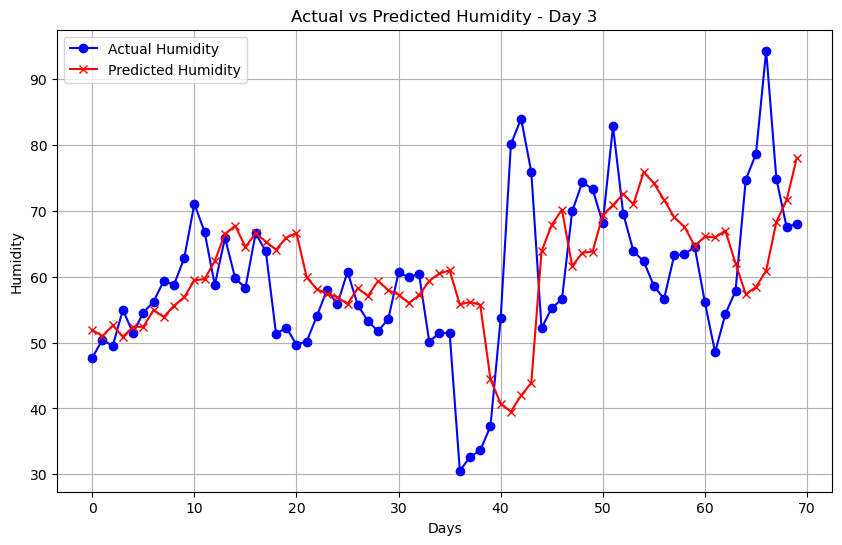

Day 4 - RMSE: 13.5742, MSE: 184.2593, MAE: 9.7697


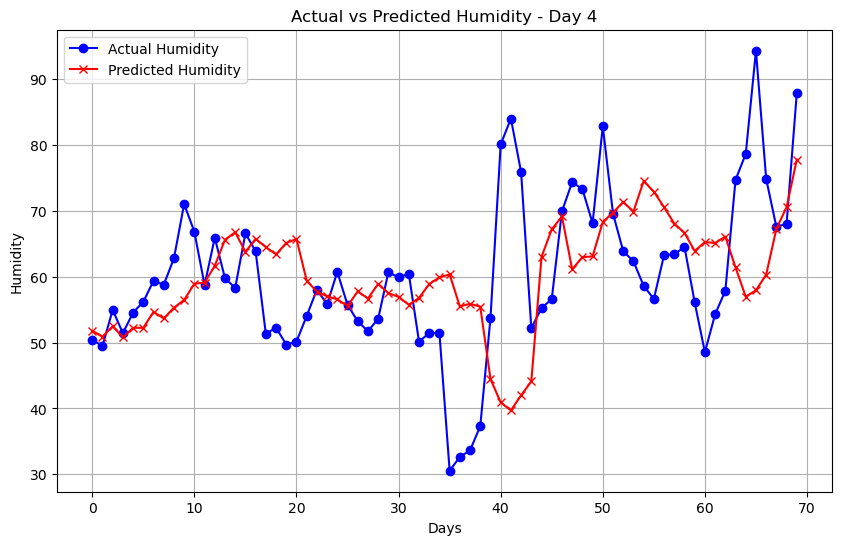

Day 5 - RMSE: 13.7002, MSE: 187.6957, MAE: 9.9835


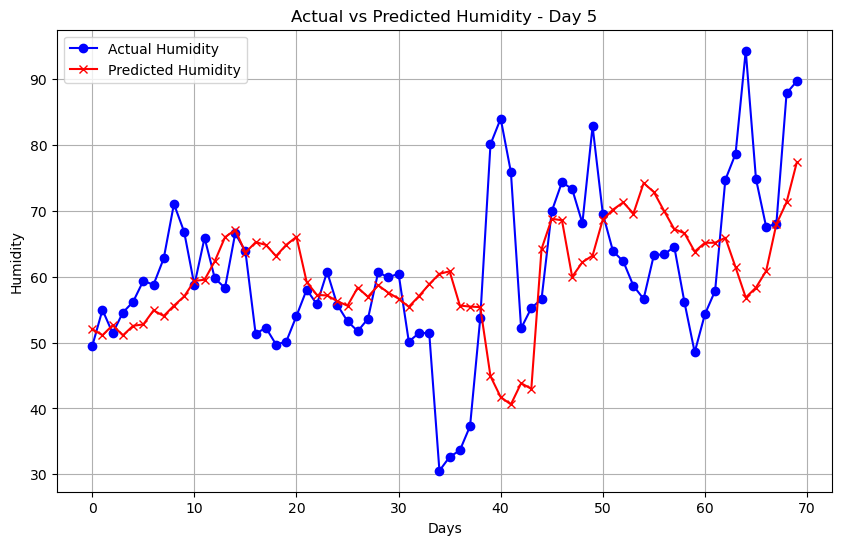

Day 6 - RMSE: 13.5807, MSE: 184.4365, MAE: 10.5944


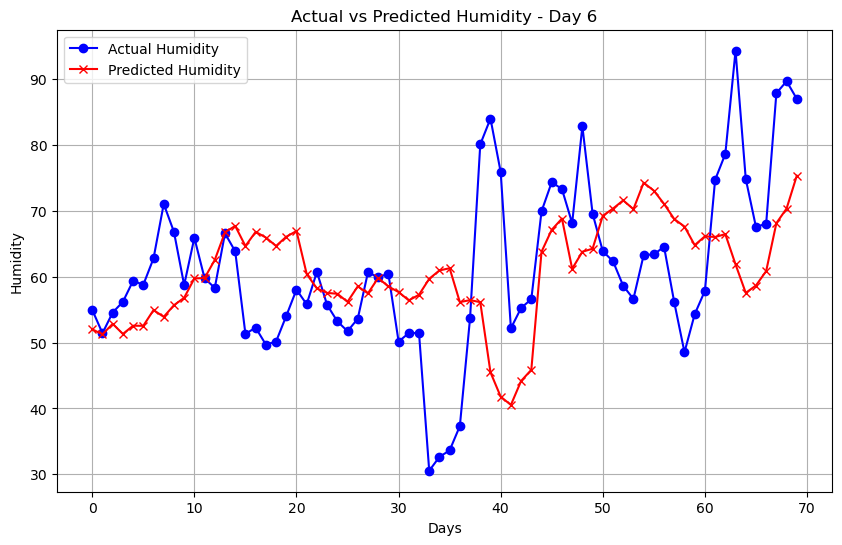

Day 7 - RMSE: 13.9719, MSE: 195.2132, MAE: 11.3067


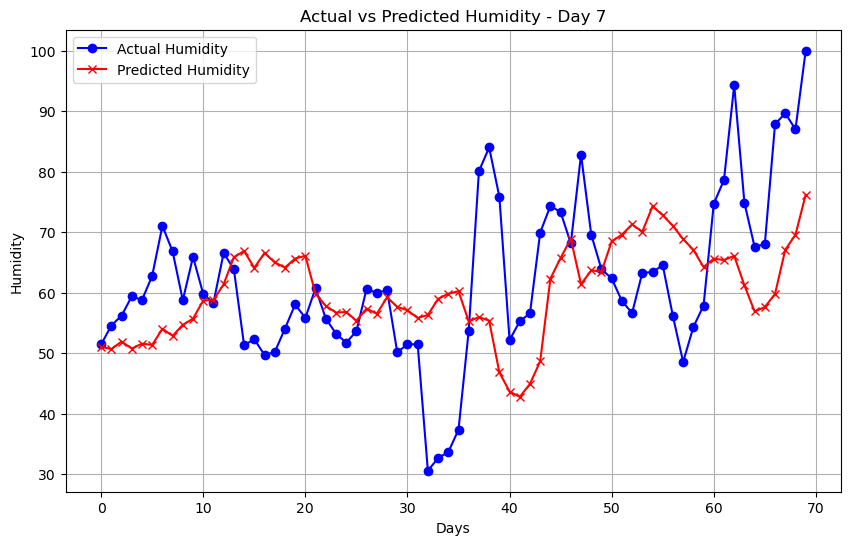

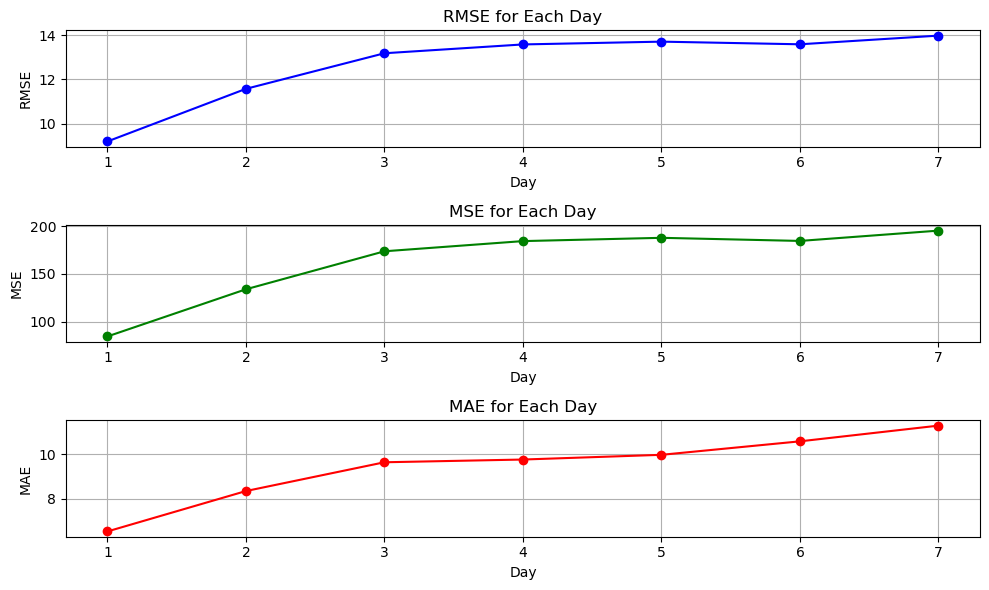

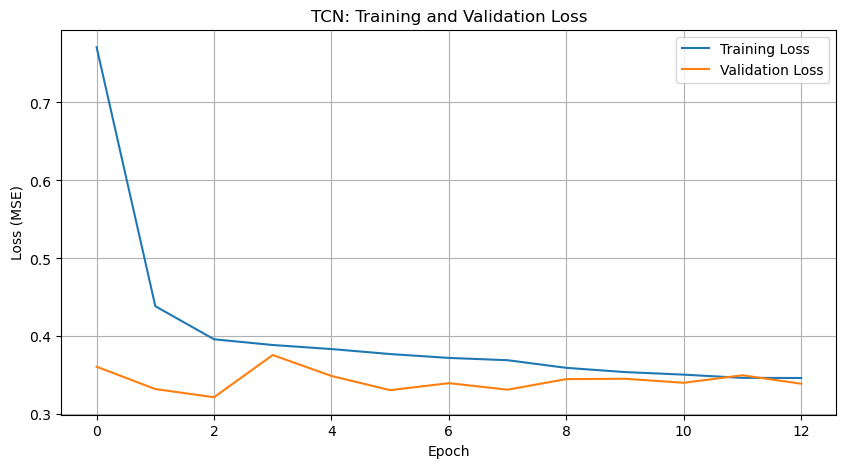

In [68]:
test_preds = np.vstack(test_preds)
test_targets = np.vstack(test_targets)

rmse_list = []
mse_list = []
mae_list = []

for i in range(forecast_horizon):
    
    humidity_init = test_targets[:, i].reshape(-1, 1)
    replicated_data = np.hstack([humidity_init] * 4) 
    inverse_transformed_data = scaler.inverse_transform(replicated_data)
    humidity_transformed_init = inverse_transformed_data[:, 1]  
 
    humidity_pred = test_preds[:, i].reshape(-1, 1)
    replicated_data_2 = np.hstack([humidity_pred] * 4)  
    inverse_transformed_data_2 = scaler.inverse_transform(replicated_data_2)
    humidity_transformed_pred = inverse_transformed_data_2[:, 1]  
    
    mse = mean_squared_error(humidity_transformed_init, humidity_transformed_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(humidity_transformed_init, humidity_transformed_pred)
    
    rmse_list.append(rmse)
    mse_list.append(mse)
    mae_list.append(mae)
    
    print(f'Day {i+1} - RMSE: {rmse:.4f}, MSE: {mse:.4f}, MAE: {mae:.4f}')
    
    plt.figure(figsize=(10, 6))
    plt.plot(humidity_transformed_init, label="Actual Humidity", color='blue', marker='o')
    plt.plot(humidity_transformed_pred, label="Predicted Humidity", color='red', marker='x')
    plt.title(f'Actual vs Predicted Humidity - Day {i+1}')
    plt.xlabel('Days')
    plt.ylabel('Humidity')
    plt.legend()
    plt.grid(True)
    plt.show()


days = np.arange(1, forecast_horizon + 1)

plt.figure(figsize=(10, 6))

plt.subplot(3, 1, 1)
plt.plot(days, rmse_list, label='RMSE', color='blue', marker='o')
plt.title('RMSE for Each Day')
plt.xlabel('Day')
plt.ylabel('RMSE')
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(days, mse_list, label='MSE', color='green', marker='o')
plt.title('MSE for Each Day')
plt.xlabel('Day')
plt.ylabel('MSE')
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(days, mae_list, label='MAE', color='red', marker='o')
plt.title('MAE for Each Day')
plt.xlabel('Day')
plt.ylabel('MAE')
plt.grid(True)

plt.tight_layout()



plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('TCN: Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()
plt.savefig('tcn_training_losses.png')
plt.close()

In [69]:
def prepare_xgb_data(X_seq, y_seq):
    X_flat = X_seq.reshape(X_seq.shape[0], -1)  
    return X_flat, y_seq

X_train_xgb, y_train_xgb = prepare_xgb_data(X_train, y_train)
X_val_xgb, y_val_xgb = prepare_xgb_data(X_val, y_val)
X_test_xgb, y_test_xgb = prepare_xgb_data(X_test, y_test)

print(f"\nXGBoost data shapes: X_train {X_train_xgb.shape}, y_train {y_train_xgb.shape}")

xgb_models = []
xgb_preds = np.zeros_like(y_test_xgb)


XGBoost data shapes: X_train (1215, 56), y_train (1215, 7)


In [70]:
for i in range(forecast_horizon):
    print(f"\nTraining XGBoost model for day {i+1}")

    dtrain = xgb.DMatrix(X_train_xgb, y_train_xgb[:, i])
    dval = xgb.DMatrix(X_val_xgb, y_val_xgb[:, i])
    dtest = xgb.DMatrix(X_test_xgb)

    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'max_depth': 6,
        'eta': 0.1,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'alpha': 0.1,
        'lambda': 1.0
    }

    evals = [(dtrain, 'train'), (dval, 'val')]
    model = xgb.train(
        params,
        dtrain,
        num_boost_round=100,
        early_stopping_rounds=10,
        evals=evals,
        verbose_eval=10
    )
    
  
    xgb_models.append(model)
    xgb_preds[:, i] = model.predict(dtest)
    
    mse = mean_squared_error(y_test_xgb[:, i], xgb_preds[:, i])
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test_xgb[:, i], xgb_preds[:, i])
    print(f'Day {i+1} - RMSE: {rmse:.4f}, MAE: {mae:.4f}')




Training XGBoost model for day 1
[0]	train-rmse:1.01724	val-rmse:0.70566


[10]	train-rmse:0.48456	val-rmse:0.48746
[20]	train-rmse:0.30982	val-rmse:0.45728
[30]	train-rmse:0.24597	val-rmse:0.45564
[33]	train-rmse:0.23112	val-rmse:0.45668
Day 1 - RMSE: 0.4669, MAE: 0.3211

Training XGBoost model for day 2
[0]	train-rmse:1.02460	val-rmse:0.70195
[10]	train-rmse:0.52833	val-rmse:0.56080
[20]	train-rmse:0.36333	val-rmse:0.54522
[27]	train-rmse:0.30656	val-rmse:0.54967
Day 2 - RMSE: 0.6450, MAE: 0.4732

Training XGBoost model for day 3
[0]	train-rmse:1.03074	val-rmse:0.69422
[10]	train-rmse:0.55192	val-rmse:0.58397
[20]	train-rmse:0.38810	val-rmse:0.59483
Day 3 - RMSE: 0.6867, MAE: 0.5030

Training XGBoost model for day 4
[0]	train-rmse:1.03431	val-rmse:0.70257
[10]	train-rmse:0.55370	val-rmse:0.64313
[18]	train-rmse:0.41240	val-rmse:0.66357
Day 4 - RMSE: 0.6989, MAE: 0.5335

Training XGBoost model for day 5
[0]	train-rmse:1.03498	val-rmse:0.68958
[10]	train-rmse:0.56830	val-rmse:0.62585
[18]	train-rmse:0.42405	val-rmse:0.64416
Day 5 - RMSE: 0.7270, MAE: 0.5384



In [181]:

print("\nComparison of TCN and XGBoost models:")
print("Average RMSE across all forecast horizons:")
tcn_rmse = np.mean([np.sqrt(mean_squared_error(test_targets[:, i], test_preds[:, i])) for i in range(forecast_horizon)])
xgb_rmse = np.mean([np.sqrt(mean_squared_error(y_test_xgb[:, i], xgb_preds[:, i])) for i in range(forecast_horizon)])
print(f"TCN: {tcn_rmse:.4f}")
print(f"XGBoost: {xgb_rmse:.4f}")


plt.figure(figsize=(12, 6))

def inverse_transform_temp(scaled_values):
   
    dummy = np.zeros((len(scaled_values), 4))
    dummy[:, 0] = scaled_values
    original_scale = scaler.inverse_transform(dummy)
    return original_scale[:, 0]


sample_size = min(50, len(test_targets))
sample_indices = np.arange(sample_size)


test_dates = df.index[-test_size:]
sample_dates = test_dates[sample_indices]

actual_temps = inverse_transform_temp(test_targets[sample_indices, 0])
tcn_pred_temps = inverse_transform_temp(test_preds[sample_indices, 0])
xgb_pred_temps = inverse_transform_temp(xgb_preds[sample_indices, 0])


plt.plot(sample_dates, actual_temps, 'b-', label='Actual Temperature')
plt.plot(sample_dates, tcn_pred_temps, 'r--', label='TCN Prediction')
plt.plot(sample_dates, xgb_pred_temps, 'g-.', label='XGBoost Prediction')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.title('1-Day Ahead Temperature Prediction')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('prediction_comparison.png')
plt.close()


if len(xgb_models) > 0:
    plt.figure(figsize=(12, 6))
    xgb.plot_importance(xgb_models[0], max_num_features=20)
    plt.title('Feature Importance for 1-Day Ahead Prediction')
    plt.tight_layout()
    plt.savefig('xgboost_feature_importance.png')
    plt.close()

print("\nModels trained and evaluated successfully!")
print("Visualizations saved as PNG files.")


Comparison of TCN and XGBoost models:
Average RMSE across all forecast horizons:
TCN: 0.7655
XGBoost: 0.6688

Models trained and evaluated successfully!
Visualizations saved as PNG files.


<Figure size 1200x600 with 0 Axes>